# Setup

In [208]:
# install.packages("dplyr")
# install.packages("pROC")
# install.packages("ggplot2")

In [209]:
library(dplyr)
library(pROC)
library(ggplot2)

In [210]:
input_dir_1 <- "../8_ROC/7-FC/FC_familias-cleaned-LR"                         # change path
output_dir_1 <- "../8_ROC/7-FC/FC_ROC"                                        # change path

# Find all cleaned LR files

In [211]:
clean_files <- list.files(
  path       = input_dir_1,
  pattern    = "^.*_cleanLR\\.txt$",                                
  full.names = TRUE
)

if (length(clean_files) == 0) {
  stop("No cleaned files found.")
}

cat("Found", length(clean_files), "cleaned LR files:\n")
print(basename(clean_files))

Found 7 cleaned LR files:
[1] "FC_23aSTR_cleanLR.txt"         "FC_23astr-90iisnp_cleanLR.txt"
[3] "FC_23astr-94iisnp_cleanLR.txt" "FC_27astr_cleanLR.txt"        
[5] "FC_27astr-94iisnp_cleanLR.txt" "FC_90iisnp_cleanLR.txt"       
[7] "FC_94iisnp_cleanLR.txt"       


# Create function to compute ROC +AUC + ggplot ROC for one panel

In [212]:
compute_roc <- function(file_path, output_dir_1) {
    df <- read.table(file_path, header = TRUE)

    #Get name of marker panel and relationship
    panel_name <- strsplit(basename(file_path), "_")[[1]][2]
    rel_name <- strsplit(basename(file_path), "_")[[1]][1]
    
    #Get colums labels of dataframe
    col_true <- names(df)[1]
    col_unrel <- names(df)[2]

    # Convert to log10(LR)
    LR_true   <- log10(df[[col_true]])
    LR_unrel  <- log10(df[[col_unrel]])

    # Labels: 1 = related, 0 = unrelated
    y   <- c(rep(1, length(LR_true)), rep(0, length(LR_unrel)))
    scores <- c(LR_true, LR_unrel)

    # ROC via pROC
    roc_obj <- roc(response = y, predictor = scores)
    auc_val <- as.numeric(auc(roc_obj))

    # Build data frame for ggplot ROC curve
    roc_df <- data.frame(
    FPR       = 1 - roc_obj$specificities,
    TPR       = roc_obj$sensitivities,
    threshold = roc_obj$thresholds,
    Panel     = panel_name
    )

    # Individual ggplot ROC curve
    p_individual <- ggplot(roc_df, aes(x = FPR, y = TPR)) +
    geom_line(size = 1.1, color = "steelblue") +
    geom_abline(slope = 1, intercept = 0, linetype = "dashed", color = "grey60") +
    coord_equal() +
    labs(
      title    = paste("ROC Curve (", rel_name, "-", panel_name, ")", sep = ""),
      subtitle = paste("AUC:", format(auc_val, digits = 15, scientific = TRUE)),
      x        = "False Positive Rate (1 - Specificity)",
      y        = "True Positive Rate (Sensitivity)"
    ) +
    theme_minimal(base_size = 14)

    # Save per-panel ROC figure
    roc_png <- file.path(output_dir_1, paste0("ROC_", rel_name, "_", panel_name, ".png"))
    ggsave(roc_png, plot = p_individual, width = 7, height = 6, dpi = 300)
    print(p_individual)
    cat("Saved individual ROC plot:", roc_png, "\n")
    
    # Return:
    # - summary row for AUC table
    # - roc_df for combined plotting
    list(
        auc_row = data.frame(
        Panel = panel_name,
        AUC = format(auc_val, digits = 20, scientific = TRUE),
        N_sim = nrow(df),
        stringsAsFactors = FALSE
        ),
        roc_df = roc_df
    )
}

# Loop over all panels


Processing: FC_23aSTR_cleanLR.txt 


Setting levels: control = 0, case = 1

Setting direction: controls < cases



Saved individual ROC plot: ../8_ROC/7-FC/FC_ROC/ROC_FC_23aSTR.png 

Processing: FC_23astr-90iisnp_cleanLR.txt 


Setting levels: control = 0, case = 1

Setting direction: controls < cases



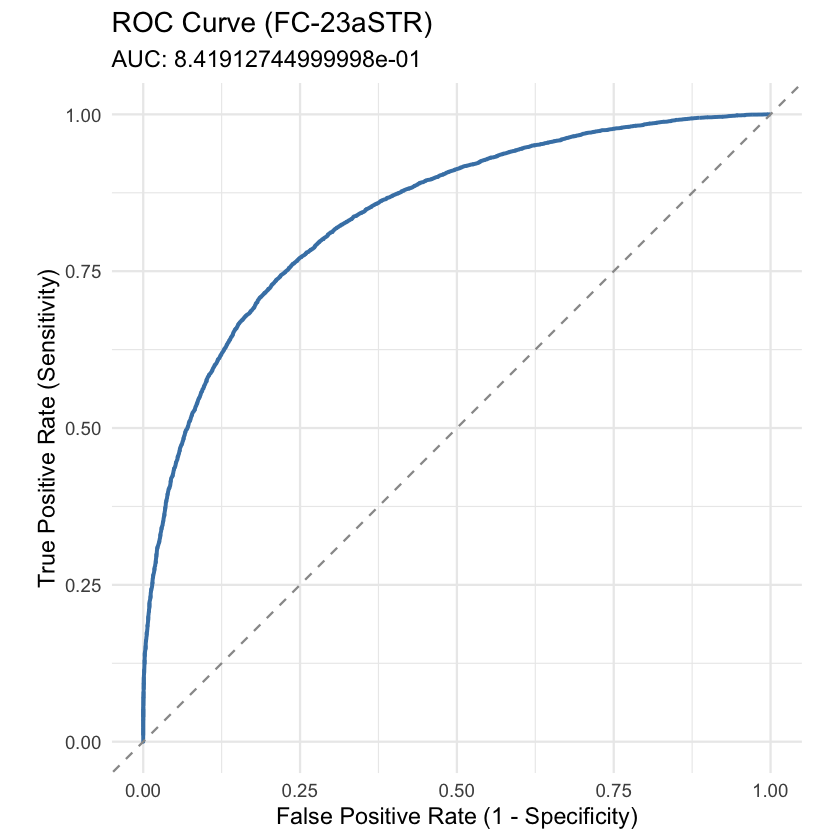

Saved individual ROC plot: ../8_ROC/7-FC/FC_ROC/ROC_FC_23astr-90iisnp.png 

Processing: FC_23astr-94iisnp_cleanLR.txt 


Setting levels: control = 0, case = 1

Setting direction: controls < cases



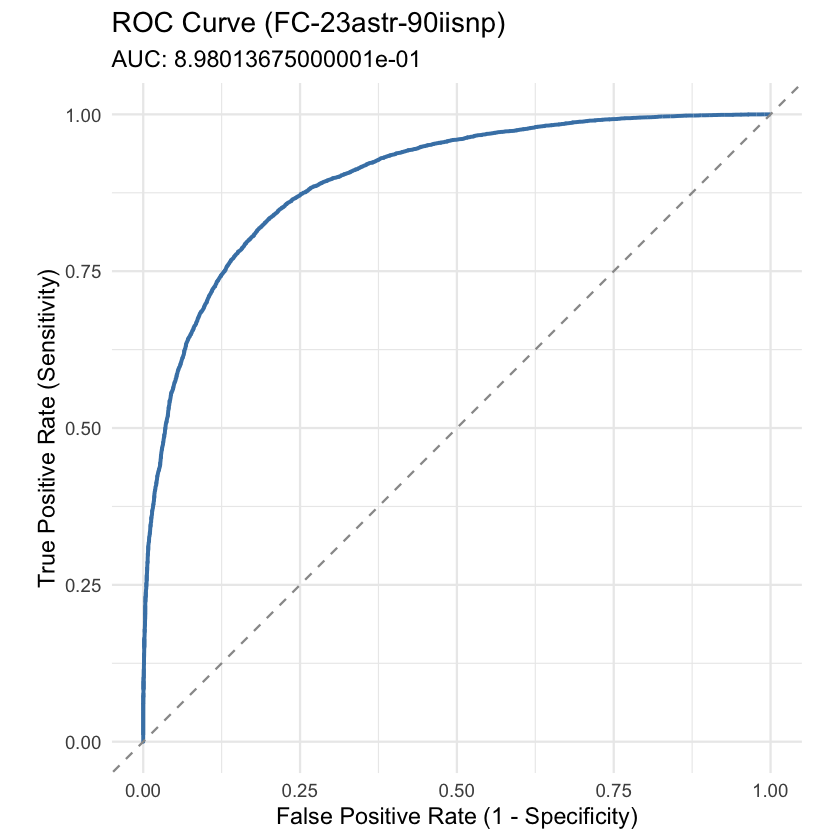

Saved individual ROC plot: ../8_ROC/7-FC/FC_ROC/ROC_FC_23astr-94iisnp.png 

Processing: FC_27astr_cleanLR.txt 


Setting levels: control = 0, case = 1

Setting direction: controls < cases



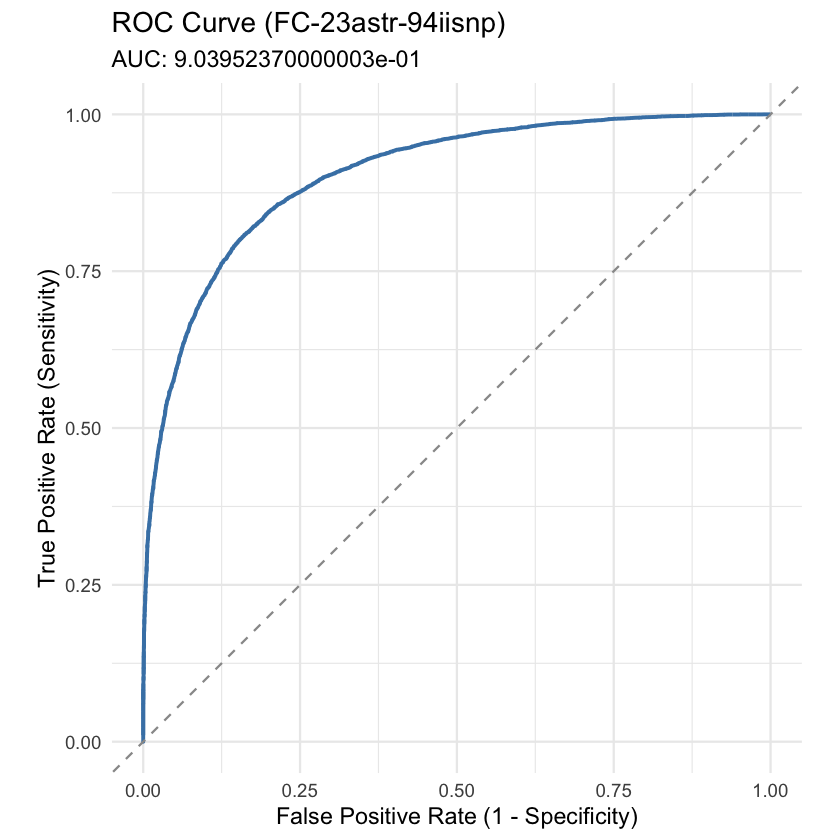

Saved individual ROC plot: ../8_ROC/7-FC/FC_ROC/ROC_FC_27astr.png 

Processing: FC_27astr-94iisnp_cleanLR.txt 


Setting levels: control = 0, case = 1

Setting direction: controls < cases



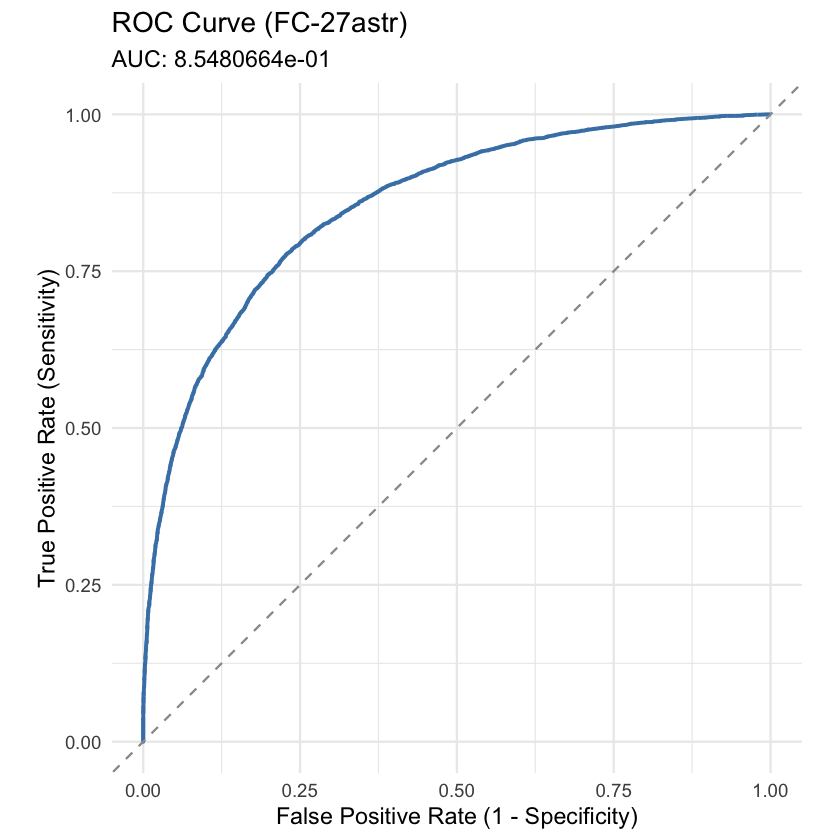

Saved individual ROC plot: ../8_ROC/7-FC/FC_ROC/ROC_FC_27astr-94iisnp.png 

Processing: FC_90iisnp_cleanLR.txt 


Setting levels: control = 0, case = 1

Setting direction: controls < cases



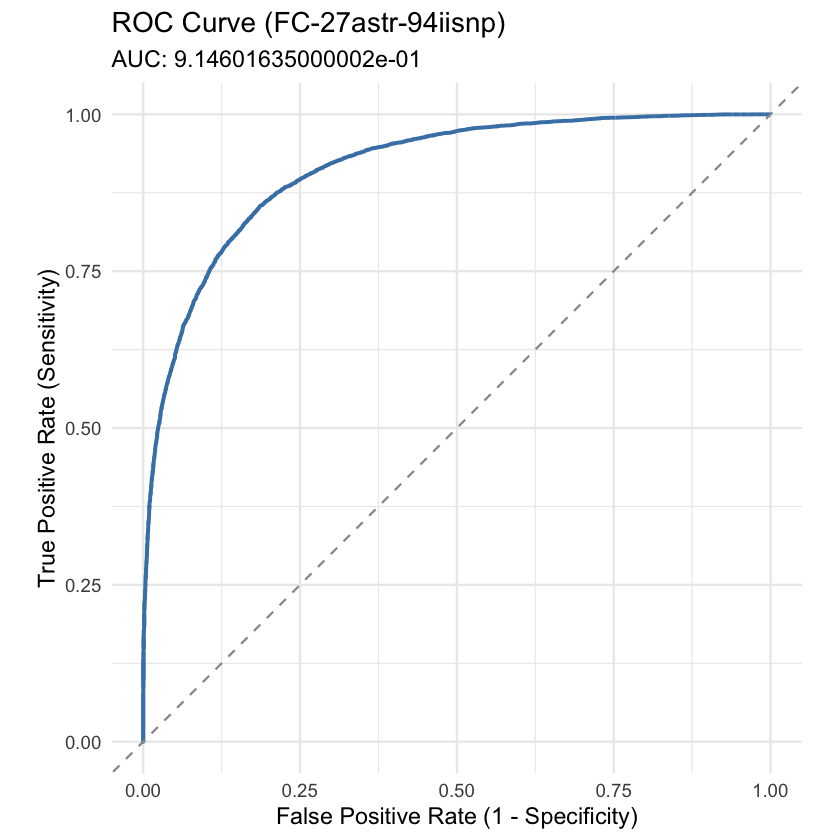

Saved individual ROC plot: ../8_ROC/7-FC/FC_ROC/ROC_FC_90iisnp.png 

Processing: FC_94iisnp_cleanLR.txt 


Setting levels: control = 0, case = 1

Setting direction: controls < cases



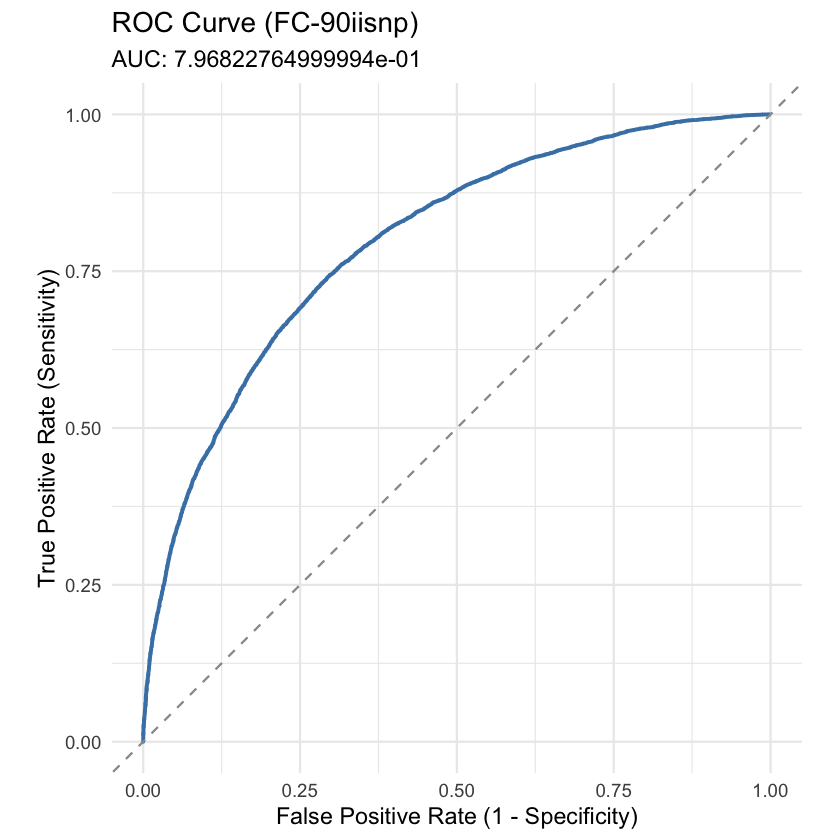

Saved individual ROC plot: ../8_ROC/7-FC/FC_ROC/ROC_FC_94iisnp.png 


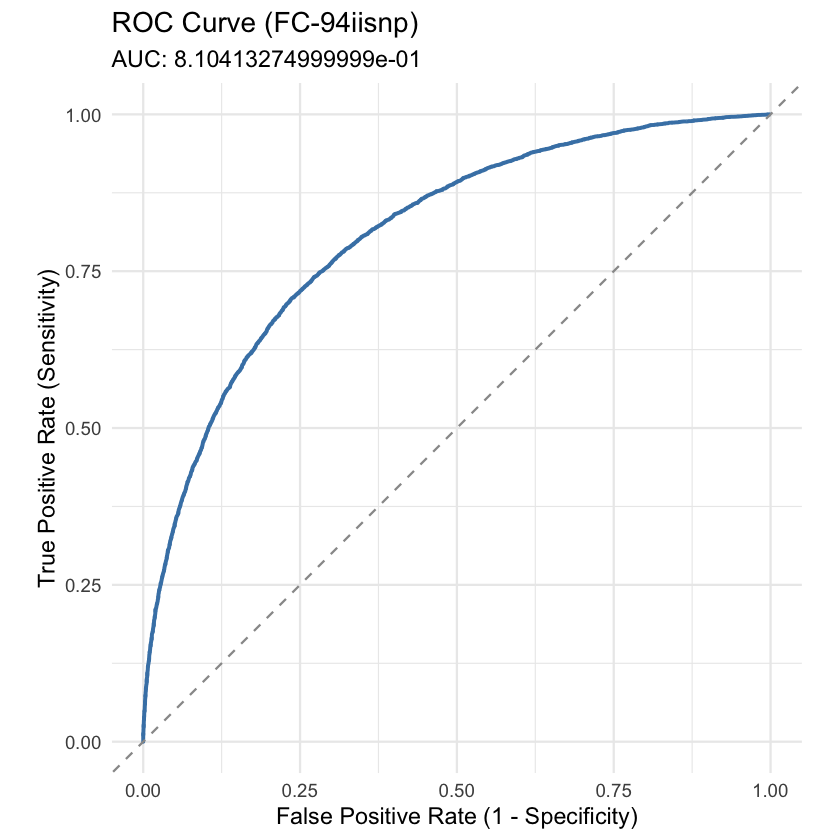

In [213]:
auc_list   <- vector("list", length(clean_files))
rocdf_list <- vector("list", length(clean_files))

for (i in seq_along(clean_files)) {
  f <- clean_files[i]
  cat("\nProcessing:", basename(f), "\n")
  res <- compute_roc(f, output_dir_1)
  auc_list[[i]]   <- res$auc_row
  rocdf_list[[i]] <- res$roc_df
}

auc_table <- bind_rows(auc_list)
roc_all   <- bind_rows(rocdf_list)

# Save AUC summary table

In [214]:
# Generate name for summary table (AUC) and plots (ROC)
summaries_label <- strsplit(basename(clean_files[1]), "_")[[1]][1]

auc_outfile <- file.path(output_dir_1, paste0("AUC_summary_", summaries_label, "_panels.txt"))

write.table(
  auc_table,
  file      = auc_outfile,
  sep       = "\t",
  quote     = FALSE,
  row.names = FALSE
)

cat("\nAUC summary table saved to:", auc_outfile, "\n")
print(auc_table)


AUC summary table saved to: ../8_ROC/7-FC/FC_ROC/AUC_summary_FC_panels.txt 
           Panel                       AUC N_sim
1         23aSTR 8.4191274499999824155e-01 10000
2 23astr-90iisnp 8.9801367500000106592e-01 10000
3 23astr-94iisnp  9.039523700000032802e-01 10000
4         27astr 8.5480663999999950686e-01 10000
5 27astr-94iisnp 9.1460163500000246639e-01 10000
6        90iisnp 7.9682276499999382668e-01 10000
7        94iisnp 8.1041327499999882278e-01 10000


# Combined ROC plot (all panels together)


Combined ROC plot saved to: ../8_ROC/7-FC/FC_ROC/ROC_FC_all_panels.png 


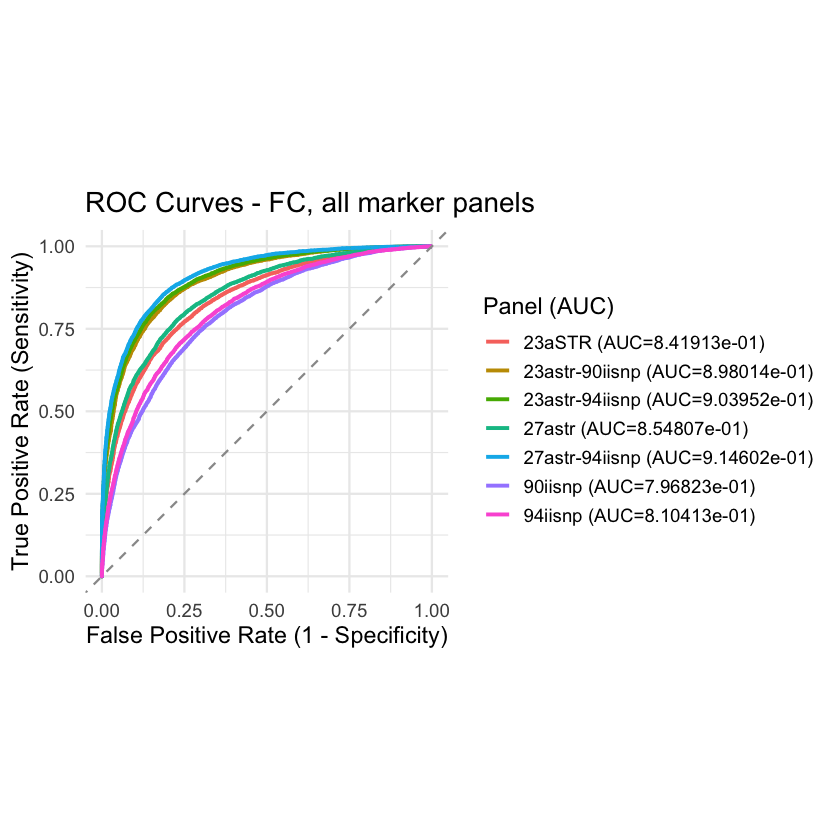

In [215]:

# Create nice labels including AUC in legend
auc_labels <- auc_table %>%
  mutate(
    PanelLabel = paste0(
      Panel,
      " (AUC=",
      format(as.numeric(AUC), digits = 6, scientific = TRUE),
      ")"
    )
  )

# Map raw Panel names to PanelLabel for legend
panel_label_map <- setNames(auc_labels$PanelLabel, auc_labels$Panel)

roc_all$Panel <- factor(roc_all$Panel, levels = auc_labels$Panel)

p_combined <- ggplot(roc_all, aes(x = FPR, y = TPR, color = Panel)) +
  geom_line(size = 1.1) +
  geom_abline(slope = 1, intercept = 0, linetype = "dashed", color = "grey60") +
  coord_equal() +
  scale_color_discrete(labels = panel_label_map[levels(roc_all$Panel)]) +
  labs(
    title = paste0("ROC Curves - ", summaries_label, ", all marker panels"),
    x     = "False Positive Rate (1 - Specificity)",
    y     = "True Positive Rate (Sensitivity)",
    color = "Panel (AUC)"
  ) +
  theme_minimal(base_size = 14)

combined_png <- file.path(output_dir_1, paste0("ROC_", summaries_label, "_all_panels.png"))
ggsave(combined_png, plot = p_combined, width = 8, height = 7, dpi = 300)

print(p_combined)

cat("\nCombined ROC plot saved to:", combined_png, "\n")